In [1]:
%matplotlib inline

In [2]:
import pulp
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import pandas as pd
import numpy as np
from random import shuffle
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# Hyper Parameters
LR = 0.02                   # learning rate
EPSILON = 0.9               # greedy policy
GAMMA = 0.9                 # reward discount
LAMBDA = 0.3# parameter decay

N_ACTIONS = 10 #no. of duty cycles (0,1,2,3,...,10)
BMIN = 0.0
BMAX = 20000.0 #Battery capacity
BOPT = 0.6 * BMAX #Assuming 60% of battery is the optimal level
HMAX = 1000
DMAX = 500
DMIN = 100

In [4]:
class ENO(object):
    def __init__(self, year=2010):
        self.year = year
        self.day = None
        self.hr = None
        
        self.TIME_STEPS = None
        self.NO_OF_DAYS = None
        
        self.BMIN = BMIN
        self.BMAX = BMAX #Battery capacity
        self.BOPT = 0.6 * self.BMAX #Assuming 60% of battery is the optimal level
        self.HMAX = HMAX
        
        self.senergy = None #matrix with harvested energy data for the entire year
        self.fforecast = None #matrix with forecast values for each day
        
        self.batt = None #battery variable
        self.enp = None #enp at end of hr
        self.henergy = None #harvested energy variable
        self.fcast = None #forecast variable
    
    #function to map total day energy into day_state
    def get_day_state(self,tot_day_energy):
        if (tot_day_energy < 2500):
            day_state = 0
        elif (2500 <= tot_day_energy < 5000):
            day_state = 1
        elif (5000 <= tot_day_energy < 8000):
            day_state = 2
        elif (8000 <= tot_day_energy < 10000):
            day_state = 3
        elif (10000 <= tot_day_energy < 12000):
            day_state = 4
        else:
            day_state = 5
        return int(day_state)

    #function to get the solar data for the given year and prep it
    def get_data(self):
        filename = str(self.year)+'.csv'
        #skiprows=4 to remove unnecessary title texts
        #usecols=4 to read only the Global Solar Radiation (GSR) values
        solar_radiation = pd.read_csv(filename, skiprows=4, encoding='shift_jisx0213', usecols=[4])
        
        #convert dataframe to numpy array
        solar_radiation = solar_radiation.values
        solar_energy = np.array([i *0.0165*1000000*0.15*1000/(60*60) for i in solar_radiation])
        
        #reshape solar_energy into no_of_daysx24 array
        _senergy = solar_energy.reshape(-1,24)
        _senergy[np.isnan(_senergy)] = 0 #convert missing data in CSV files to zero
        self.senergy = np.clip(_senergy,0,self.HMAX) #limit the amount of harvested energy to HMAX        
        
        #create a perfect forecaster
        tot_day_energy = np.sum(_senergy, axis=1) #contains total energy harvested on each day
        get_day_state = np.vectorize(self.get_day_state)
        self.fforecast = get_day_state(tot_day_energy)
        
        return 0
    
    def reset(self):
        
        self.get_data() #first get data for the given year
        
        self.TIME_STEPS = self.senergy.shape[1]
        self.NO_OF_DAYS = self.senergy.shape[0]
        
        print("Environment is RESET")
        
        self.day = 0
        self.hr = 0
        
        self.batt = self.BOPT #battery returns to optimal level
        self.enp = self.BOPT - self.batt #enp is reset to zero
        self.henergy = self.senergy[self.day][self.hr] 
        self.fcast = self.fforecast[self.day]
        
        norm_batt = self.batt/self.BMAX
        norm_enp = self.enp/(self.BMAX/2)
        norm_henergy = self.henergy/self.HMAX
        norm_fcast = self.fcast/5

        state = [norm_batt, norm_enp, norm_henergy, norm_fcast]
        reward = 0
        done = False
        info = "RESET"
        return [state, reward, done, info]
    
    
    #reward function
    def rewardfn(self):
        mu = 0
        sig = 1000
        norm_enp = self.enp/(self.BMAX/2)
        if(np.abs(norm_enp) <= DMIN*self.TIME_STEPS/(BMAX/2)): # DMIN*self.TIME_STEPS/(BMAX/2) - normalized value of worst case power consumption at min duty cycle
            return ((1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((self.enp - mu)/sig, 2.)/2)) * 1E6)
        else:
            return -100 - 0.05*np.abs(self.enp)
    
    def step(self, action):
        done = False
        info = "OK"
        reward = 0
        e_consumed = (action+1)*DMAX/N_ACTIONS
        
        self.batt += (self.henergy - e_consumed)
        self.batt = np.clip(self.batt, self.BMIN, self.BMAX)
        self.enp = self.BOPT - self.batt
        
        if(self.hr < self.TIME_STEPS - 1):
            self.hr += 1
            self.henergy = self.senergy[self.day][self.hr] 
        else:
            if(self.day < self.NO_OF_DAYS -1):
                reward = self.rewardfn() #give reward only at the end of the day
                self.hr = 0
                self.day += 1
                self.henergy = self.senergy[self.day][self.hr] 
                self.fcast = self.fforecast[self.day]
            else:
                reward = self.rewardfn()
                done = True
                info = "End of the year"
        
        norm_batt = self.batt/self.BMAX
        norm_enp = self.enp/(self.BMAX/2)
        norm_henergy = self.henergy/self.HMAX
        norm_fcast = self.fcast/5

        _state = [norm_batt, norm_enp, norm_henergy, norm_fcast]
        return [_state, reward, done, info]
                
        #we normalize the enp w.r.t. half of the battery level
        #this may give weird results if BOPT varies by a great amount from 0.5*BMAX
    
    def getstate(self):
        norm_batt = self.batt/self.BMAX
        norm_enp = self.enp/(self.BMAX/2)
        norm_henergy = self.henergy/self.HMAX
        norm_fcast = self.fcast/5
        state = [norm_batt, norm_enp, norm_henergy, norm_fcast]
               
        return state

In [5]:
class SARSA(object):
    def __init__(self):
        self.no_of_batt_state = 3;
        self.no_of_enp_state = 42;
        self.no_of_henergy_state = 30;
        self.no_of_day_state = 6;
        self.no_of_actions = N_ACTIONS;
        self.q_init = 200;
        self.q = np.zeros((self.no_of_batt_state, self.no_of_enp_state, self.no_of_henergy_state, self.no_of_day_state, self.no_of_actions)) + self.q_init
        self.e = np.zeros_like(self.q)

    
    def get_batt_state(self,batt):
        if (batt < 0.3):
            batt_state = 0
        elif (0.3<= batt <0.8):
            batt_state = 1
        else:
            batt_state = 2
        
        return int(batt_state)
    
    def get_enp_state(self,enp):
        #assuming the battery deviates equally in both enp directions
        #NEEDS TO BE RETHOUGHT AND UPDATED
#         enp_max = 0.5
#         enp_min = 0
        
        enp = np.clip(enp,-0.5,0.5)
        _enp = 0.5 + enp
        enp_state = np.ceil(_enp*self.no_of_enp_state)
        
        enp_state = np.clip(enp_state, 0, self.no_of_enp_state-1)
        return int(enp_state)
    
    def get_henergy_state(self,henergy):
        henergy_state = int(np.floor(henergy*self.no_of_henergy_state))
        henergy_state = np.clip(henergy_state, 0, self.no_of_henergy_state-1)
        return int(henergy_state)
    
    def get_fcast_state(self,fcast):
        return fcast * 5
    
    def discretize(self,ps):
        s = np.zeros(4)
        s[0] = self.get_batt_state(ps[0])
        s[1] = self.get_enp_state(ps[1])
        s[2] = self.get_henergy_state(ps[2])
        s[3] = self.get_fcast_state(ps[3])
        return s.astype(int)
        
    def choose_action(self,s):
        [batt_state, enp_state, henergy_state, day_state] = s
        # This is how to choose an action
        q_values = self.q[batt_state, enp_state, henergy_state,  day_state, :]
        max_q_value = np.max(q_values)
        max_action = np.argmax(q_values)
        if (np.random.uniform() < EPSILON) or ((q_values == 0).all()):  # select randomly if exploring or 
                                                                             #if state-action values are ALL zero
            action = np.random.randint(1,N_ACTIONS)
        else:   # act greedy
            action = max_action
        return int(action)
    
    def choose_greedy_action(self,s):
        [batt_state, enp_state, henergy_state, day_state] = s
        # This is how to choose an action
        q_values = self.q[batt_state, enp_state, henergy_state,  day_state, :]
        max_q_value = np.max(q_values)
        max_action = np.argmax(q_values)
        if ((q_values == 0).all()):  #if state-action values are ALL zero
             action = np.random.randint(1,N_ACTIONS)
        else:   # act greedy
            action = max_action
        return int(action)
    
    def learn(self,transition, terminal):
        [s,a,r,s_,a_] = transition
        [batt_state, enp_state, henergy_state, day_state] = s
        [batt_state_, enp_state_, henergy_state_, day_state_] = s_
        
        if (terminal):
            del_ = r - self.q[batt_state, enp_state, henergy_state, day_state, a]
        else:
            del_ = GAMMA*self.q[batt_state_, enp_state_, henergy_state_, day_state_, a_] \
                    - self.q[batt_state, enp_state, henergy_state, day_state, a]
       
        #update eligibility trace and q-table
        self.e[batt_state, enp_state, henergy_state,  day_state, a] += 1
        qerr = LR*del_*self.e
        self.q += qerr #update the entire qtable
        self.e = GAMMA*LAMBDA*self.e #decay eligibility



In [6]:
eno = ENO(2010)
eno.reset()
sarsa = SARSA()

Environment is RESET


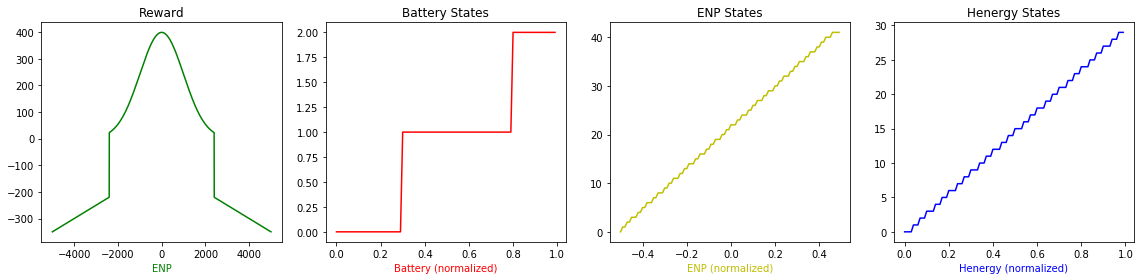

In [7]:
#Check reward function
#ENP varies from -0.5 to 0.5
y1 = np.empty(1)
for x in np.arange(-5000,5000):
    eno.enp = x
    y1 = np.append(y1,eno.rewardfn())
y1 = np.delete(y1, 0, 0) #remove the first row which is garbage

#Check state discretiziation functions
#Battery value varies from 0 to 1
y2 = np.empty(1)
for x in np.arange(0,1,0.01):
    temp = sarsa.get_batt_state(x)
    y2 = np.append(y2,temp)
y2 = np.delete(y2, 0, 0) #remove the first row which is garbage

#Check state discretiziation functions
#ENP value varies from -0.5 to 0.5
#Inconsistent with the reward function 
y3 = np.empty(1)
for x in np.arange(-0.5,0.5,0.01):
    temp = sarsa.get_enp_state(x)
    y3 = np.append(y3,temp)
y3 = np.delete(y3, 0, 0) #remove the first row which is garbage

#Check state discretiziation functions
#henergy value varies from 0 to 1
y4 = np.empty(1)
for x in np.arange(0,1,0.01):
    temp = sarsa.get_henergy_state(x)
    y4 = np.append(y4,temp)
y4 = np.delete(y4, 0, 0) #remove the first row which is garbage


####################################
##   PRINT FIGURES##################
fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(1,4,1)
ax1.set_title("Reward")
ax1.set_xlabel("ENP",color='g')
ax1.plot(np.arange(-5000,5000),y1,'g')

ax2 = fig.add_subplot(1,4,2)
ax2.set_title("Battery States")
ax2.set_xlabel("Battery (normalized)",color='r')
ax2.plot(np.arange(0,1,0.01),y2,'r')

ax3 = fig.add_subplot(1,4,3)
ax3.set_title("ENP States")
ax3.set_xlabel("ENP (normalized)",color='y')
ax3.plot(np.arange(-0.5,0.5,0.01),y3,'y')

ax4 = fig.add_subplot(1,4,4)
ax4.set_title("Henergy States")
ax4.set_xlabel("Henergy (normalized)",color='b')
ax4.plot(np.arange(0,1,0.01),y4,'b')

fig.tight_layout()
plt.show()


Environment is RESET
End of Year

Day run test
Environment is RESET
End of Year
Average Reward:  -289.21107854892654


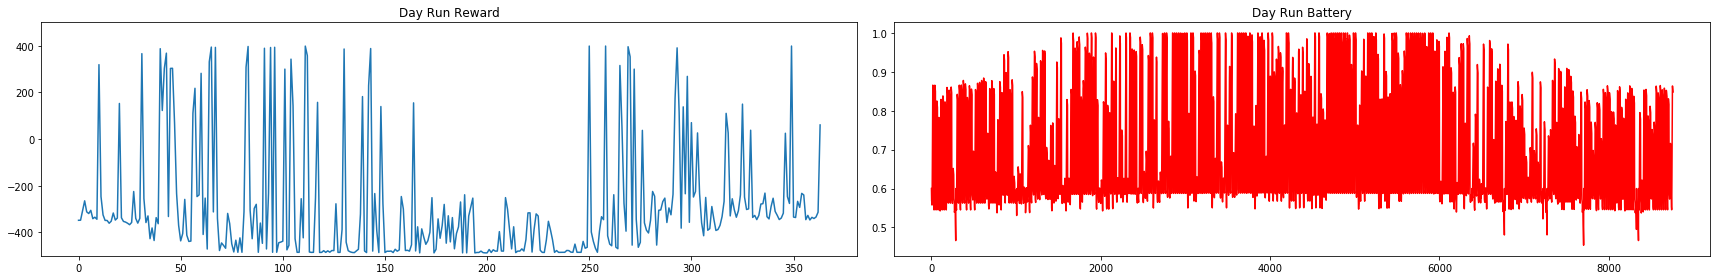


Environment is RESET
End of Year

Day run test
Environment is RESET
End of Year
Average Reward:  -285.12954662574356


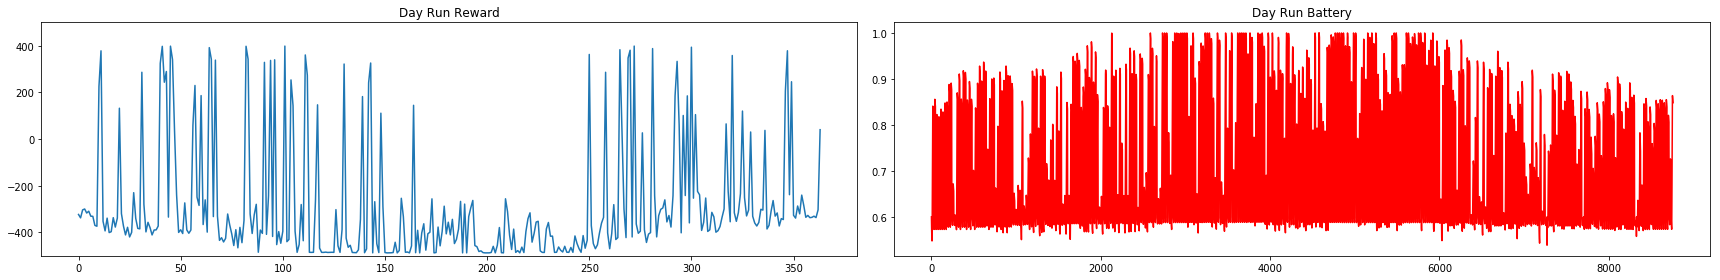


Environment is RESET
End of Year

Day run test
Environment is RESET
End of Year
Average Reward:  -281.5102498760491


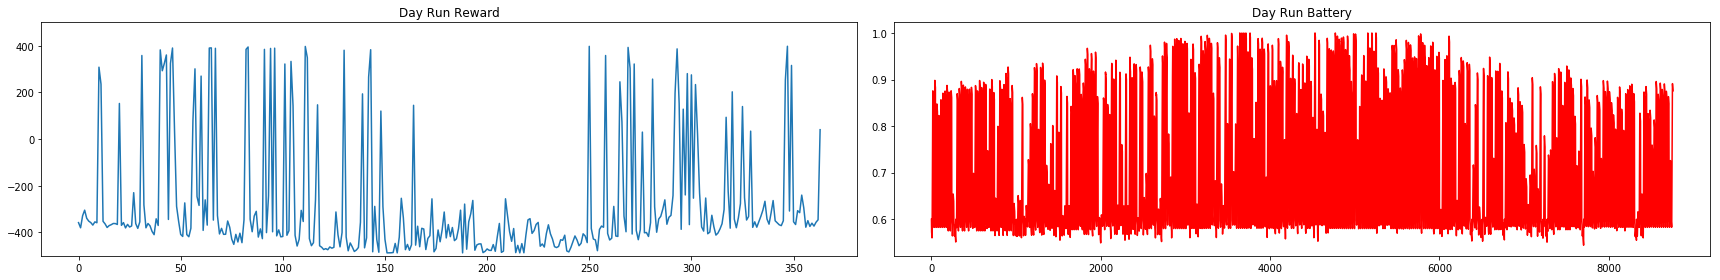


Environment is RESET
End of Year

Day run test
Environment is RESET
End of Year
Average Reward:  -266.8231654648677


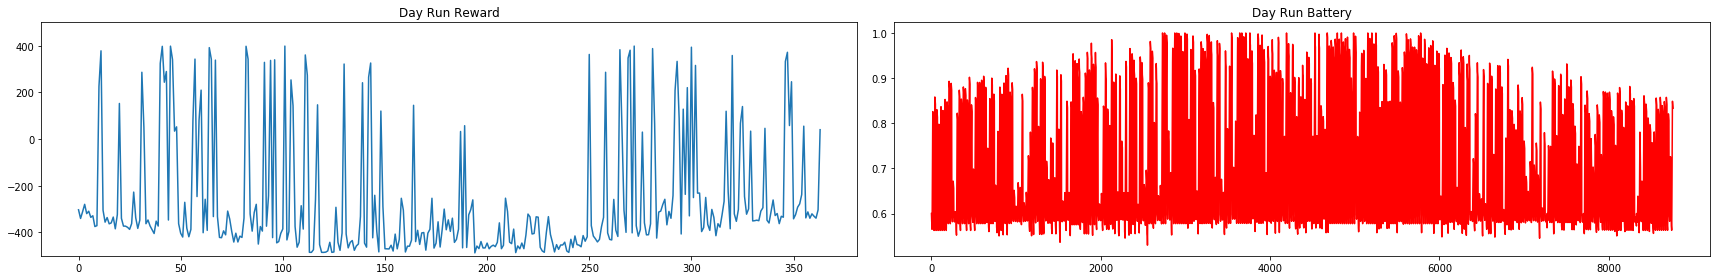


Environment is RESET
End of Year

Day run test
Environment is RESET
End of Year
Average Reward:  -273.73569854583815


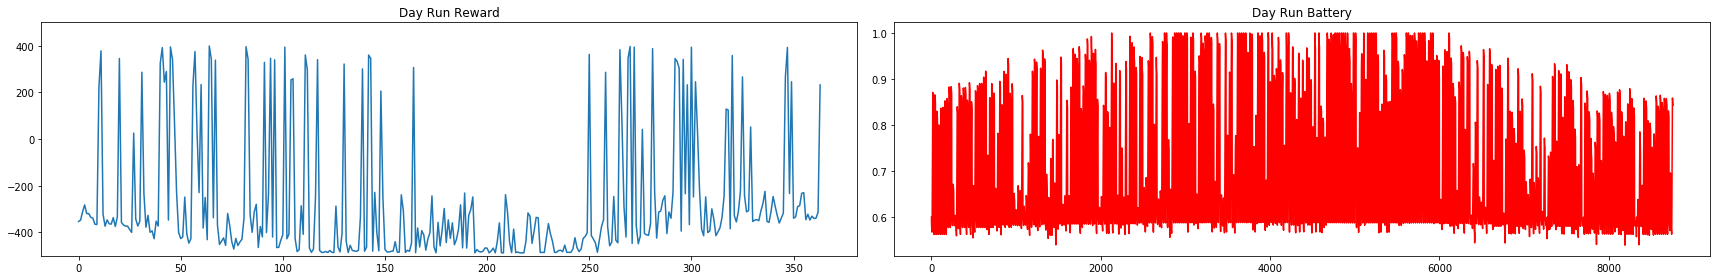


Environment is RESET
End of Year

Day run test
Environment is RESET
End of Year
Average Reward:  -285.17085804198985


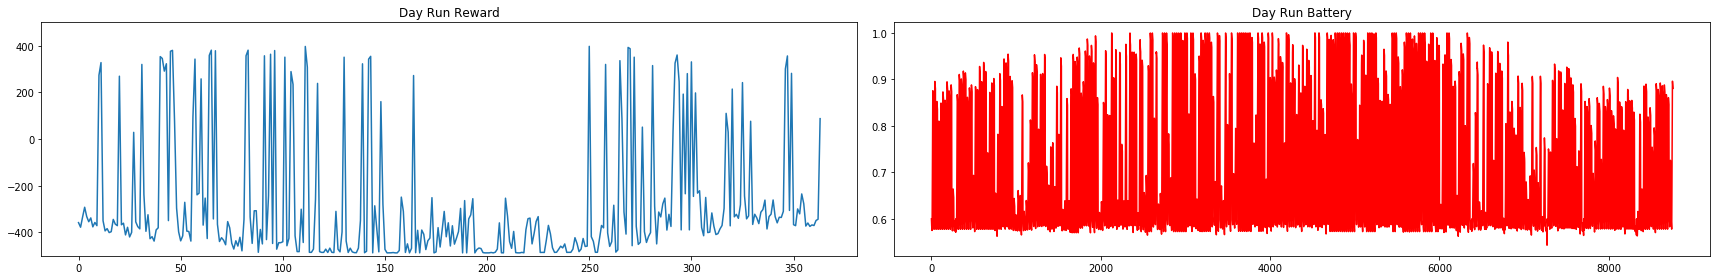


Environment is RESET
End of Year

Day run test
Environment is RESET
End of Year
Average Reward:  -236.34229845084099


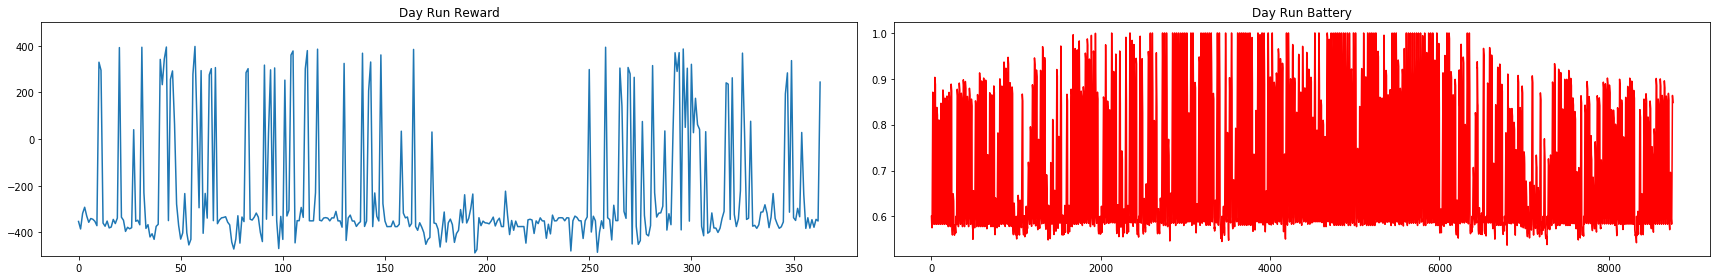


Environment is RESET
End of Year

Day run test
Environment is RESET
End of Year
Average Reward:  -242.56546146212992


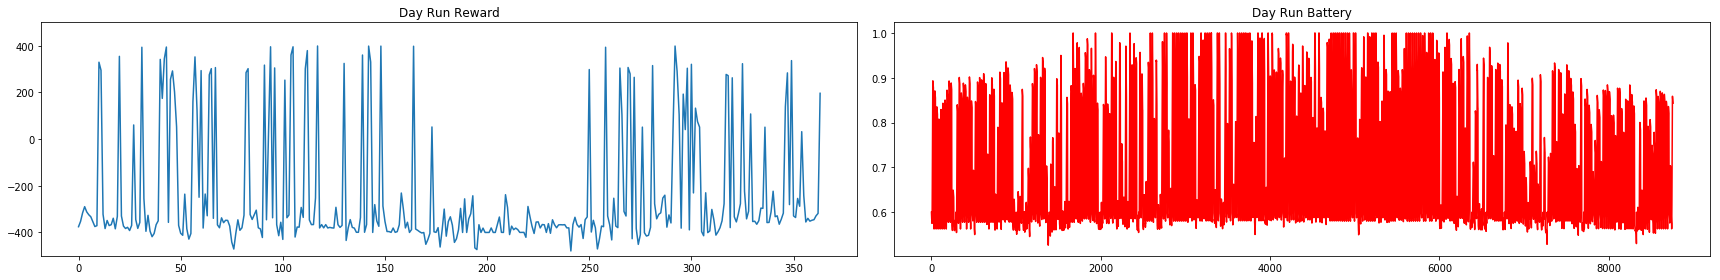


Environment is RESET
End of Year

Day run test
Environment is RESET
End of Year
Average Reward:  -249.39466962513325


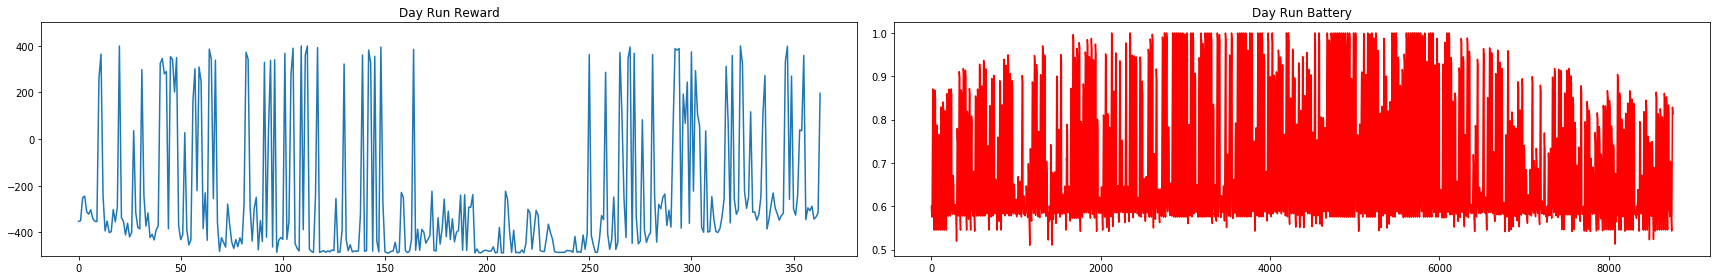


Environment is RESET
End of Year

Day run test
Environment is RESET
End of Year
Average Reward:  -232.89916940401272


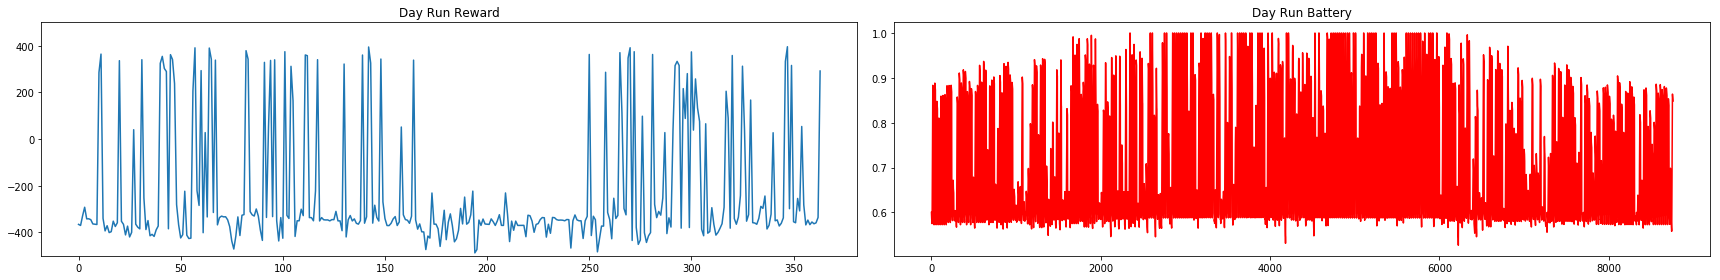


Environment is RESET
End of Year

Day run test
Environment is RESET
End of Year
Average Reward:  -248.46708706896342


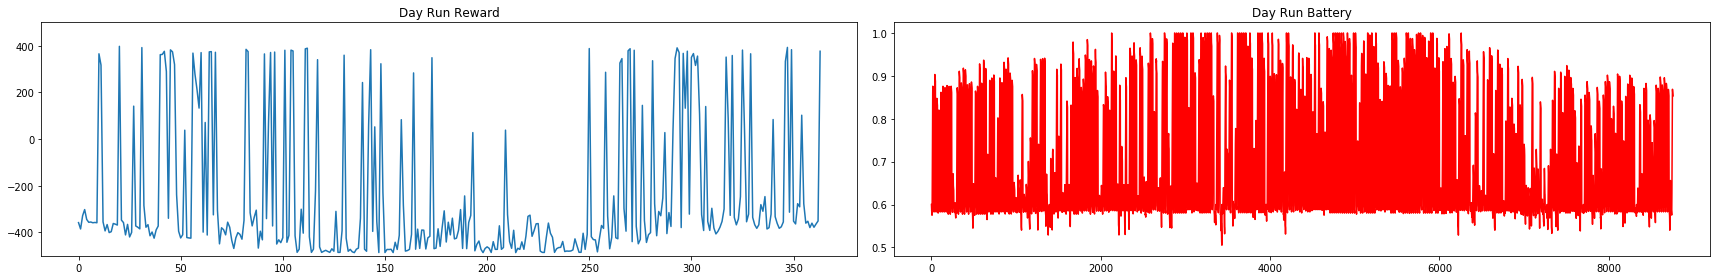


Environment is RESET
End of Year

Day run test
Environment is RESET
End of Year
Average Reward:  -252.34664570902672


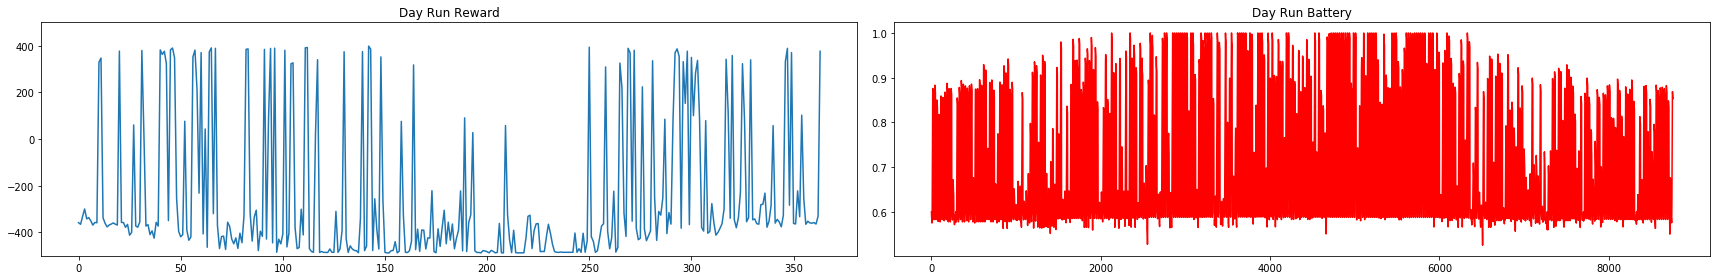


Environment is RESET
End of Year

Day run test
Environment is RESET
End of Year
Average Reward:  -251.18740158111578


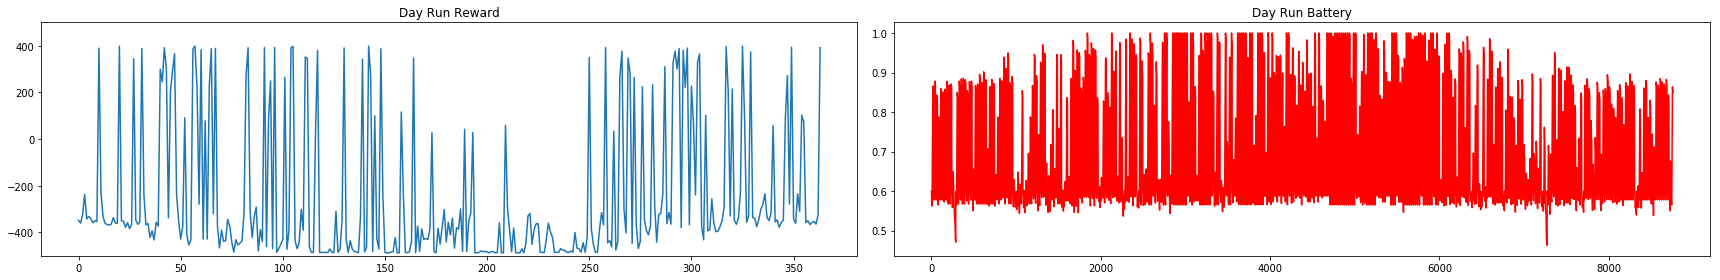


Environment is RESET
End of Year

Day run test
Environment is RESET
End of Year
Average Reward:  -210.03556251730095


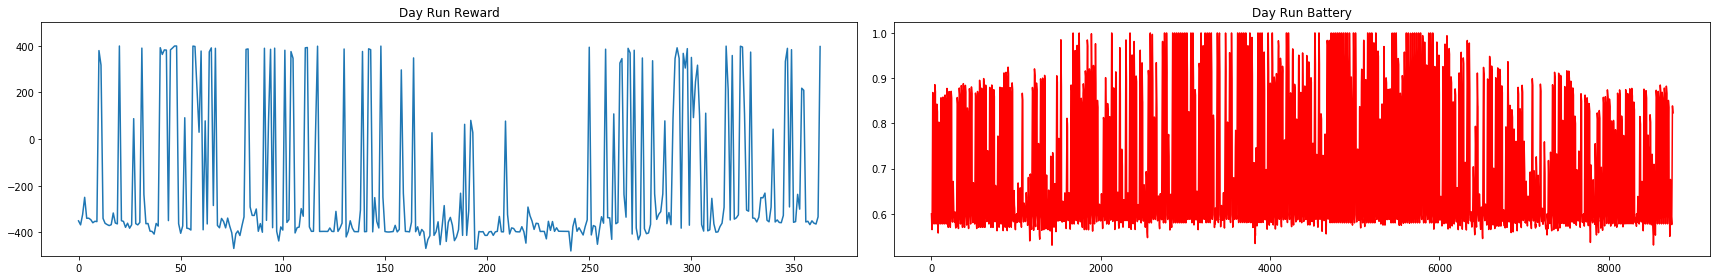


Environment is RESET
End of Year

Day run test
Environment is RESET
End of Year
Average Reward:  -196.56072562535556


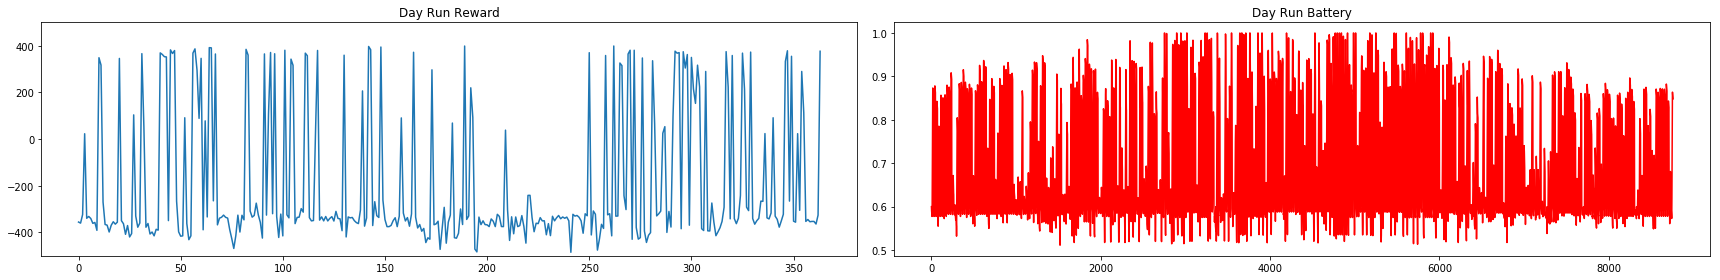


Environment is RESET
End of Year

Day run test
Environment is RESET
End of Year
Average Reward:  -214.79100008971494


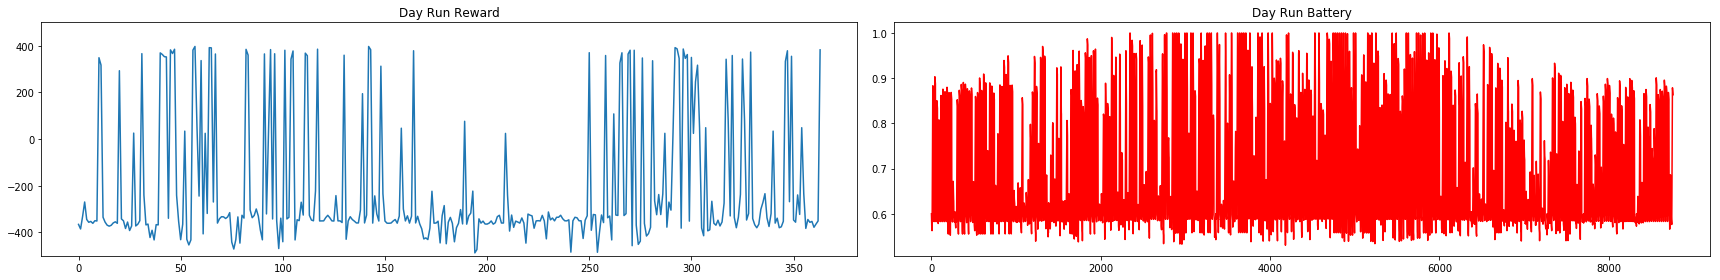


Environment is RESET


In [ ]:
NO_OF_ITERATIONS = 200
avg_reward_rec = np.empty(1)

for iteration in range(NO_OF_ITERATIONS):
    
    ############################################################################################
    #LEARN BY RESETTING BATTERY EVERYDAY
    print('\nCollecting experience... Iteration:', iteration)

    ps, r, done, info = eno.reset()
    while True:
        s = sarsa.discretize(ps)
        a = sarsa.choose_action(s)
        ns, r, done, info = eno.step(a)

        if eno.hr == 0: #flag to let the sarsa algorithm know that the reward has been obtained
            terminal = True
            eno.batt = eno.BOPT
            ns = eno.getstate()
        else:
            terminal = False
        
        s_ = sarsa.discretize(ns)
        a_ = sarsa.choose_action(s_)        
        transition = [s,a,r,s_,a_]
        
        sarsa.learn(transition,terminal)
        if done:
            print("End of Year")
            break

        ps = ns
    
    ############################################################################################
    #TEST
    print('\nDay run test')
    ps, r, done, info = eno.reset()
    yr_test_record = np.empty(4)

    while True:
        s = sarsa.discretize(ps)
        a = sarsa.choose_greedy_action(s)

        yr_test_record = np.vstack((yr_test_record, [ps[0],ps[2],r, a])) #record battery, henergy, reward and action

        ns, r, done, info = eno.step(a)

            
        if eno.hr == 0: #flag to let the sarsa algorithm know that the reward has been obtained
            eno.batt = eno.BOPT
            ns = eno.getstate()

        s_ = sarsa.discretize(ns)
        a_ = sarsa.choose_action(s_)        

        if done:
            print("End of Year")
            break

        ps = ns

    yr_test_record = np.delete(yr_test_record, 0, 0) #remove the first row which is garbage
    yr_test_reward_rec = yr_test_record[:,2]
    yr_test_reward_rec = yr_test_reward_rec[yr_test_reward_rec != 0]
    print("Average Reward: ", np.mean(yr_test_reward_rec))
    avg_reward_rec = np.append(avg_reward_rec, np.mean(yr_test_reward_rec))


    ############################################################################################
    #PLOT
    fig = plt.figure(figsize=(24,4))
    ax1 = fig.add_subplot(121)
    ax1.plot(yr_test_reward_rec)
    ax1.set_title("Day Run Reward")
    ax1.set_ylim([-500,500])

    ax2 = fig.add_subplot(122)
    ax2.plot(yr_test_record[:,0],'r')
    ax2.set_title("Day Run Battery")
    # ax2.set_ylim([0,1])

    fig.tight_layout()
    plt.show()

#PLOT THE AVERAGE REWARD OVER THE ITERATIONS
avg_reward_rec = np.delete(avg_reward_rec, 0, 0) #remove the first row which is garbage
plt.plot(avg_reward_rec,'g')

In [ ]:
avg_reward_rec = np.delete(avg_reward_rec, 0, 0) #remove the first row which is garbage
fig2 = plt.figure()
plt.plot(avg_reward_rec,'g')

In [ ]:
plt.plot(avg_reward_rec,'g')

In [ ]:
avg_reward_rec

In [ ]:
# # Verifying learned Q-table over a year
# print('\nYear run test')
# ps, r, done, info = eno.reset()
# yr_test_record = np.empty(4)

# while True:
#     s = sarsa.discretize(ps)
#     a = sarsa.choose_greedy_action(s)
    
# #     print("\nBatt: ", eno.batt)
# #     print("Henergy: ", eno.henergy)
# #     print("Action: ", (a+1)/10*DMAX)

#     yr_test_record = np.vstack((yr_test_record, [ps[0],ps[2],r, a])) #record battery, henergy, reward and action
# #     print("**************")
# #     print("Batt: ", ps[0])
# #     print("Henergy: ", ps[2])
# #     print("Action: ", a)


#     ns, r, done, info = eno.step(a)
    
#     if eno.hr == 0: #flag to let the sarsa algorithm know that the reward has been obtained
#         terminal = True
#     else:
#         terminal = False
    
#     s_ = sarsa.discretize(ns)
#     a_ = sarsa.choose_action(s_)        
# #     transition = [s,a,r,s_,a_]

# #     sarsa.learn(transition,terminal)
#     if done:
#         print("End of Year")
#         break

#     ps = ns

# yr_test_record = np.delete(yr_test_record, 0, 0) #remove the first row which is garbage

In [ ]:
# yr_test_reward_rec = yr_test_record[:,2]
# yr_test_reward_rec = yr_test_reward_rec[yr_test_reward_rec != 0]

# day_test_reward_rec = day_test_record[:,2]
# day_test_reward_rec = day_test_reward_rec[day_test_reward_rec != 0]


# fig = plt.figure(figsize=(24,4))
# ax1 = fig.add_subplot(221)
# ax1.plot(yr_test_reward_rec)
# ax1.set_title("Year Run Reward")
# # ax1.set_ylim([-400,400])

# ax2 = fig.add_subplot(222)
# ax2.plot(yr_test_record[:,0],'r')
# ax2.set_title("Year Run Battery")
# # ax2.set_ylim([0,1])

# ax3 = fig.add_subplot(223)
# ax3.plot(day_test_reward_rec)
# ax3.set_title("Day Run Reward")
# # ax3.set_ylim([-400,400])

# ax4 = fig.add_subplot(224)
# ax4.plot(day_test_record[:,0],'r')
# ax4.set_title("Day Run Battery")
# # ax4.set_ylim([0,1])

# fig.tight_layout()

In [ ]:
# TIME_AXIS = np.arange(0,eno.TIME_STEPS)
# for DAY in range(eno.NO_OF_DAYS):
#     START = DAY*24
#     END = START+24

#     fig = plt.figure(figsize=(16,4))
#     st = fig.suptitle("DAY %s" %(DAY))

#     ax2 = fig.add_subplot(131)
#     ax2.plot(yr_test_record[START:END,1],'g')
#     ax2.set_title("Harvested Energy")
#     plt.xlabel("Hour")
#     ax2.set_ylim([0,1.2])

#     #plot battery for year run
#     ax1 = fig.add_subplot(132)
#     ax1.plot(TIME_AXIS,yr_test_record[START:END,0],'r') 
#     ax1.plot(TIME_AXIS, np.ones(eno.TIME_STEPS)*eno.BOPT/eno.BMAX,'r--')
#     ax1.set_title("YEAR RUN")
#     if END < (eno.NO_OF_DAYS*eno.TIME_STEPS):
#         ax1.text(12, 0, "REWARD = %.2f\n" %(yr_test_record[END,2]),fontsize=11, ha='center')
#     plt.xlabel("Hour")
#     ax1.set_ylabel('Battery', color='r',fontsize=12)
#     ax1.set_ylim([0,1.2])

#     #plot actions for year run
#     ax1a = ax1.twinx()
#     ax1a.plot(yr_test_record[START:END,3])
#     ax1a.set_ylim([0,N_ACTIONS])
#     ax1a.set_ylabel('Duty Cycle', color='b',fontsize=12)

    
    
#     #plot battery for day run
#     ax3 = fig.add_subplot(133)
#     ax3.plot(TIME_AXIS,day_test_record[START:END,0],'r') 
#     ax3.plot(TIME_AXIS, np.ones(eno.TIME_STEPS)*eno.BOPT/eno.BMAX,'r--')
#     ax3.set_title("DAY RUN")
#     if END < (eno.NO_OF_DAYS*eno.TIME_STEPS):
#         ax3.text(12, 0, "REWARD = %.2f\n" %(day_test_record[END,2]),fontsize=11, ha='center')
#     plt.xlabel("Hour")
#     ax3.set_ylabel('Battery', color='r',fontsize=12)
#     ax3.set_ylim([0,1.2])
    
#     #plot actions for day run
#     ax3a = ax3.twinx()
#     ax3a.plot(day_test_record[START:END,3])
#     ax3a.set_ylim([0,N_ACTIONS])
#     ax3a.set_ylabel('Duty Cycle', color='b',fontsize=12)

#     fig.tight_layout()
#     st.set_y(0.95)
#     fig.subplots_adjust(top=0.75)
#     plt.show()